<a href="https://colab.research.google.com/github/Rajarajeswari-B/Amazon-Music-Clustering/blob/main/Amazon_Music_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Set visualization style
sns.set(style="whitegrid")
%matplotlib inline

In [3]:
# Load dataset
try:
    df = pd.read_csv('single_genre_artists.csv')
    print("Dataset Loaded Successfully!")
    print(f"Shape: {df.shape}")

    # View first 5 rows
    display(df.head())

    # Check for missing values
    print("\nMissing Values:")
    print(df.isnull().sum())
except FileNotFoundError:
    print("Error: File 'single_genre_artists.csv' not found. Please upload it.")

Dataset Loaded Successfully!
Shape: (95837, 23)


,id_songs,name_song,popularity_songs,duration_ms,explicit,id_artists,release_date,danceability,energy,key,...,acousticness,instrumentalness,liveness,valence,tempo,time_signature,followers,genres,name_artists,popularity_artists
0,0IA0Hju8CAgYfV1hwhidBH,La Java,0,161427,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.563,0.184,4,...,0.993,0.000016,0.325,0.654,133.088,3,5078.0,['vintage chanson'],Mistinguett,22
1,1b8HZQCqcqwbzlA1jRTp6E,En Douce,0,223440,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.427,0.180,10,...,0.989,0.000000,0.128,0.431,78.459,3,5078.0,['vintage chanson'],Mistinguett,22
2,5d5gQxHwYovxR5pqETOIAa,J'en Ai Marre,0,208267,0,4AxgXfD7ISvJSTObqm4aIE,1922,0.511,0.206,0,...,0.995,0.000000,0.418,0.481,70.443,4,5078.0,['vintage chanson'],Mistinguett,22
3,1EO65UEEPfy7CR0NK2sDxy,Ils n'ont pas ca,0,161933,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.676,0.467,9,...,0.991,0.000000,0.219,0.726,129.775,4,5078.0,['vintage chanson'],Mistinguett,22
4,6a58gXSgqbIsXUhVZ6ZJqe,La belote,0,167973,0,4AxgXfD7ISvJSTObqm4aIE,1924,0.650,0.298,9,...,0.991,0.000000,0.373,0.844,75.950,4,5078.0,['vintage chanson'],Mistinguett,22



Missing Values:
id_songs              0
name_song             0
popularity_songs      0
duration_ms           0
explicit              0
id_artists            0
release_date          0
danceability          0
energy                0
key                   0
loudness              0
mode                  0
speechiness           0
acousticness          0
instrumentalness      0
liveness              0
valence               0
tempo                 0
time_signature        0
followers             0
genres                0
name_artists          0
popularity_artists    0
dtype: int64


In [4]:
print('\nChecking for duplicate rows:')
duplicate_rows = df[df.duplicated()]

if not duplicate_rows.empty:
    print(f"Found {len(duplicate_rows)} duplicate rows.")
    display(duplicate_rows)
else:
    print("No duplicate rows found.")


Checking for duplicate rows:
No duplicate rows found.


In [5]:
# 1. Feature Selection: Keep only relevant audio metrics
feature_cols = [
    'danceability', 'energy', 'loudness', 'speechiness',
    'acousticness', 'instrumentalness', 'liveness',
    'valence', 'tempo', 'duration_ms'
]

# 2. Drop unnecessary columns for clustering logic
# We save the metadata (track_name, etc.) in a separate variable to link back later
metadata = df[['name_song', 'name_artists', 'id_songs']]
X = df[feature_cols].copy()

# 3. Handle Missing Values (if any)
X = X.fillna(X.mean())

# 4. Normalization (StandardScaler)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Preprocessing Complete.")
print(f"Scaled Feature Matrix Shape: {X_scaled.shape}")

Preprocessing Complete.
Scaled Feature Matrix Shape: (95837, 10)


In [6]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(data=X_pca, columns=['PC1', 'PC2'])
print("PCA complete. Data reduced to 2 components for visualization.")

PCA complete. Data reduced to 2 components for visualization.


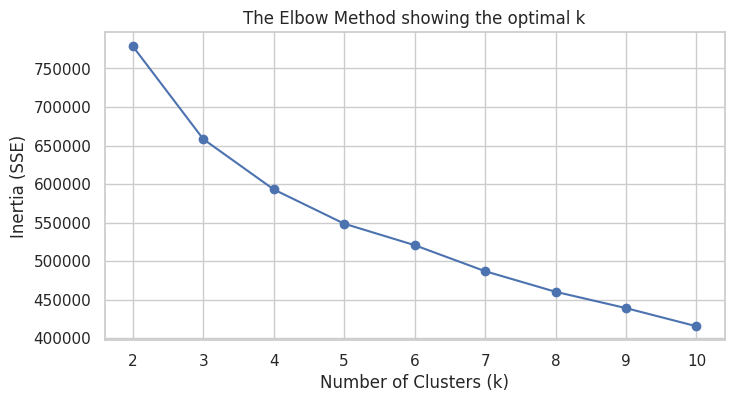

In [7]:
inertia = []
K_range = range(2, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (SSE)')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [12]:
# Set k based on the elbow observed above (using 5 as a standard example)
k = 5
kmeans_model = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans_model.fit_predict(X_scaled)

# Add labels back to dataframes
df['cluster'] = cluster_labels
pca_df['cluster'] = cluster_labels

# Calculate Silhouette Score
score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score for k={k}: {score:.4f}")
print("(Score ranges from -1 to 1. Closer to 1 is better separation)")

Silhouette Score for k=5: 0.1864
(Score ranges from -1 to 1. Closer to 1 is better separation)


In [9]:
from sklearn.metrics import silhouette_score, davies_bouldin_score

# ==============================
# 1. EVALUATION METRICS
# ==============================
print("--- 📊 Cluster Evaluation Metrics ---")

# A. Inertia: Lower is better (measures compactness)
inertia = kmeans_model.inertia_
print(f"Inertia (SSE): {inertia:.2f}")

# B. Silhouette Score: Closer to 1 is better (measures separation)
s_score = silhouette_score(X_scaled, cluster_labels)
print(f"Silhouette Score: {s_score:.4f}")

# C. Davies-Bouldin Index: Lower is better (measures ratio of within-cluster to between-cluster distance)
db_index = davies_bouldin_score(X_scaled, cluster_labels)
print(f"Davies-Bouldin Index: {db_index:.4f}")

print("\nInterpretation:")
print(f"- Your Silhouette Score of {s_score:.2f} suggests " +
      ("strong" if s_score > 0.5 else "moderate" if s_score > 0.2 else "weak") + " cluster separation.")


--- 📊 Cluster Evaluation Metrics ---
Inertia (SSE): 548594.92
Silhouette Score: 0.1864
Davies-Bouldin Index: 1.6888

Interpretation:
- Your Silhouette Score of 0.19 suggests weak cluster separation.


In [10]:
# ==============================
# CLUSTER PROFILING & INTERPRETATION
# ==============================

# 1. Calculate the mean values for each feature per cluster
cluster_means = df.groupby('cluster')[feature_cols].mean()

print("--- 🎧 Cluster Personality Profiles --- \n")

# 2. Iterate through each cluster to define its nature
for cluster_id in range(k):
    # Get the average values for this specific cluster
    stats = cluster_means.loc[cluster_id]

    # Logic to build the description based on high/low values
    # We compare the cluster mean to the overall dataset mean to see what makes it unique
    characteristics = []
    label = ""

    # Logic for "Party Tracks"
    if stats['danceability'] > 0.6 and stats['energy'] > 0.6:
        label = "Party Tracks"
        characteristics.append(f"high danceability ({stats['danceability']:.2f})")
        characteristics.append(f"high energy ({stats['energy']:.2f})")

    # Logic for "Chill Acoustic"
    elif stats['acousticness'] > 0.5 and stats['energy'] < 0.4:
        label = "Chill Acoustic"
        characteristics.append(f"high acousticness ({stats['acousticness']:.2f})")
        characteristics.append(f"low energy ({stats['energy']:.2f})")

    # Logic for "Instrumental / Focus"
    elif stats['instrumentalness'] > 0.5:
        label = "Instrumental Focus"
        characteristics.append(f"high instrumentalness ({stats['instrumentalness']:.2f})")
        characteristics.append(f"low valence ({stats['valence']:.2f})")

    # Logic for "High Intensity / Loud"
    elif stats['loudness'] > -6.0 or stats['energy'] > 0.8:
        label = "High Intensity"
        characteristics.append(f"high energy ({stats['energy']:.2f})")
        characteristics.append(f"high loudness ({stats['loudness']:.2f} dB)")

    # Fallback for other combinations
    else:
        label = "General Mix / Melodic"
        characteristics.append(f"valence ({stats['valence']:.2f})")
        characteristics.append(f"tempo ({stats['tempo']:.0f} BPM)")

    # 3. Print the Result in your requested format
    feature_str = ", ".join(characteristics)
    print(f"Cluster {cluster_id} = {feature_str} → “{label}”")

    # Show a few examples of songs that fell into this cluster
    sample_songs = df[df['cluster'] == cluster_id]['name_song'].head(3).tolist()
    print(f"   Sample Songs: {', '.join(sample_songs)}\n")

--- 🎧 Cluster Personality Profiles --- 

Cluster 0 = high danceability (0.71), high energy (0.67) → “Party Tracks”
   Sample Songs: On M'suit, Je N'suis Pas Celle Que Vous Croyez, La Noce À Rebecca

Cluster 1 = high instrumentalness (0.82), low valence (0.45) → “Instrumental Focus”
   Sample Songs: Veux Tu Que J'te Fasse Un Dessin, West End Blues, Beau Koo Jack

Cluster 2 = valence (0.58), tempo (100 BPM) → “General Mix / Melodic”
   Sample Songs: Dites Moi Doumergue, Il N'osait Pas Se Decider, L'amour Excuse Tout

Cluster 3 = high acousticness (0.74), low energy (0.31) → “Chill Acoustic”
   Sample Songs: La Java, En Douce, J'en Ai Marre

Cluster 4 = valence (0.49), tempo (136 BPM) → “General Mix / Melodic”
   Sample Songs: Hella Often Freestyle, Ditty Diego, 100 Years from Now



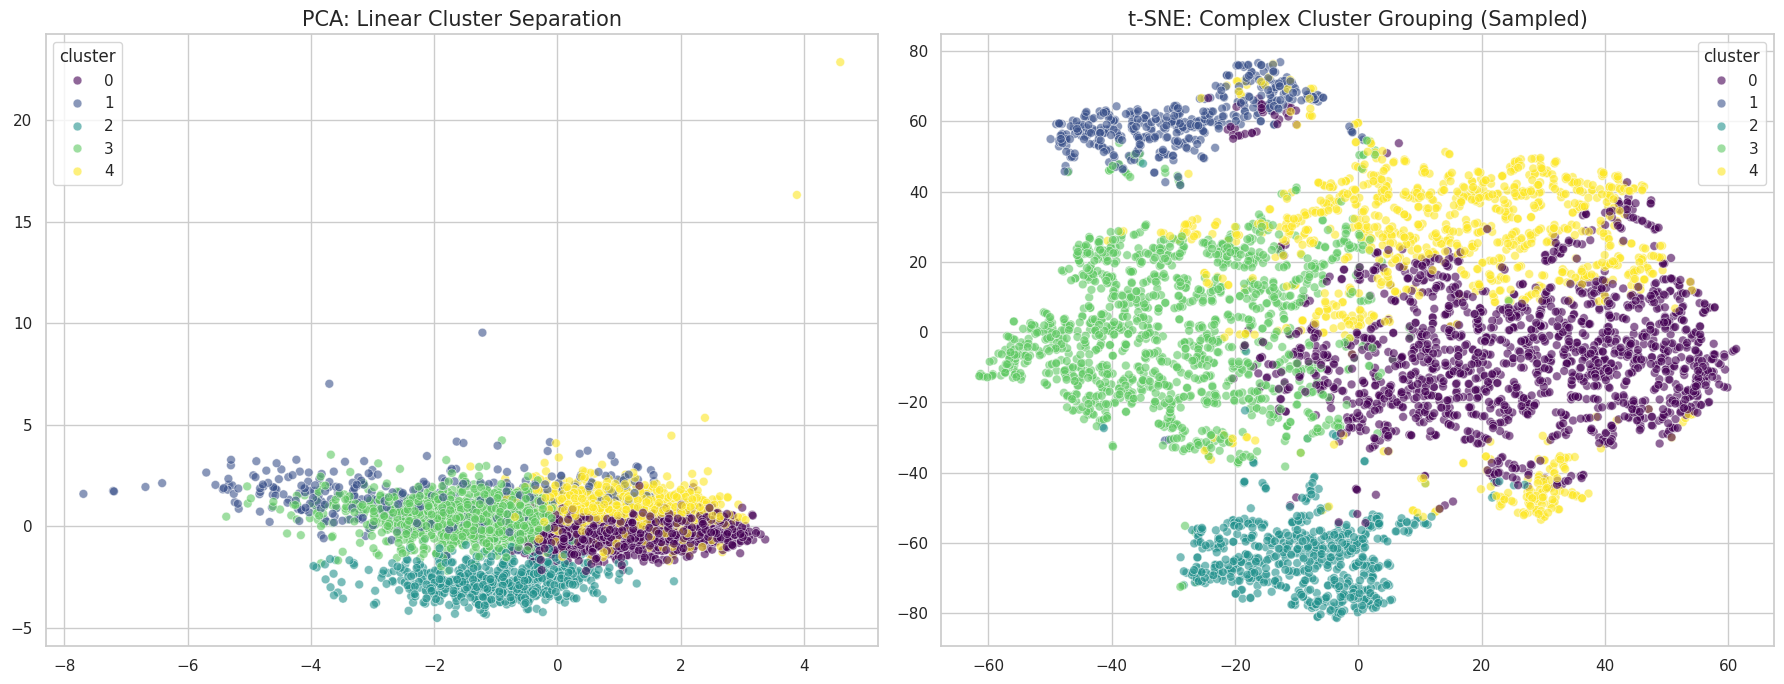

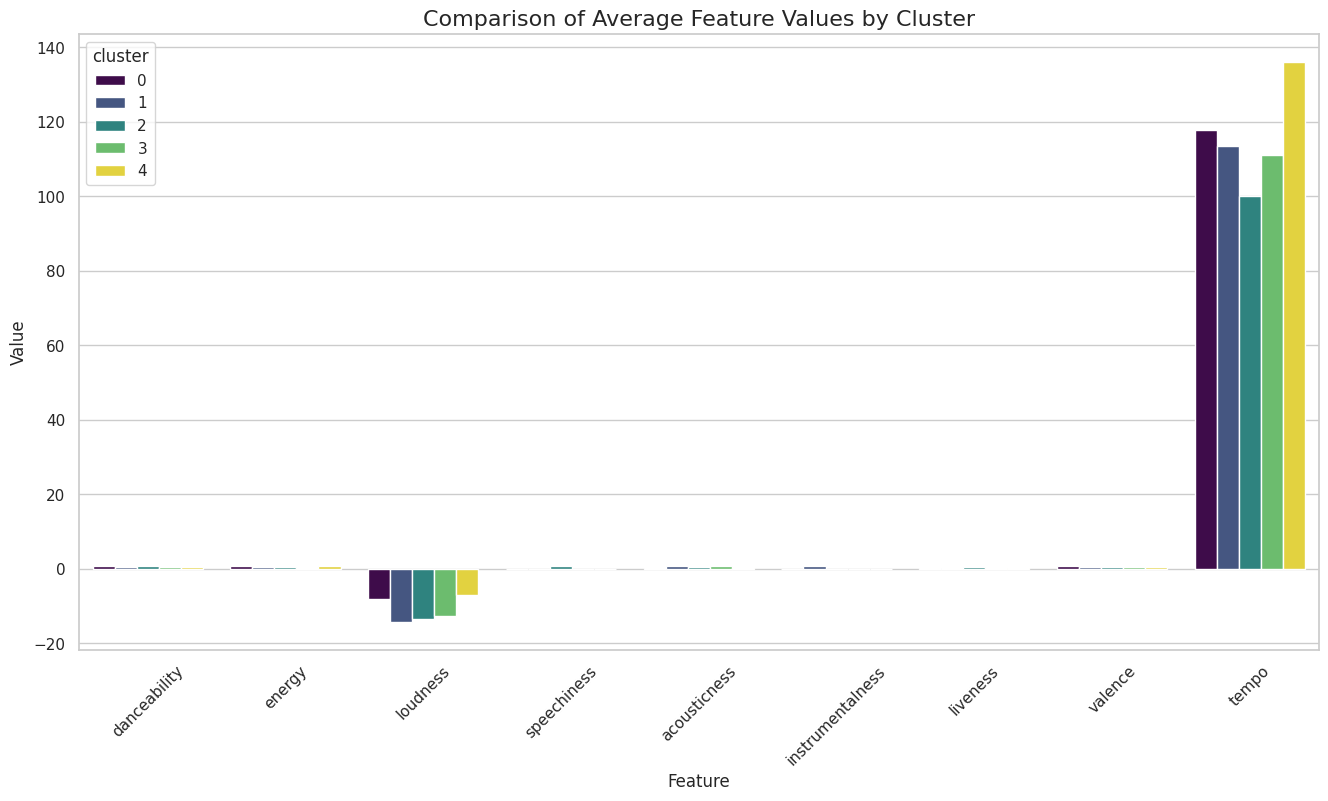

/tmp/ipython-input-3399585865.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='danceability', palette='viridis', ax=axes[0])
/tmp/ipython-input-3399585865.py:62: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sample, x='cluster', y='tempo', palette='viridis', ax=axes[1])


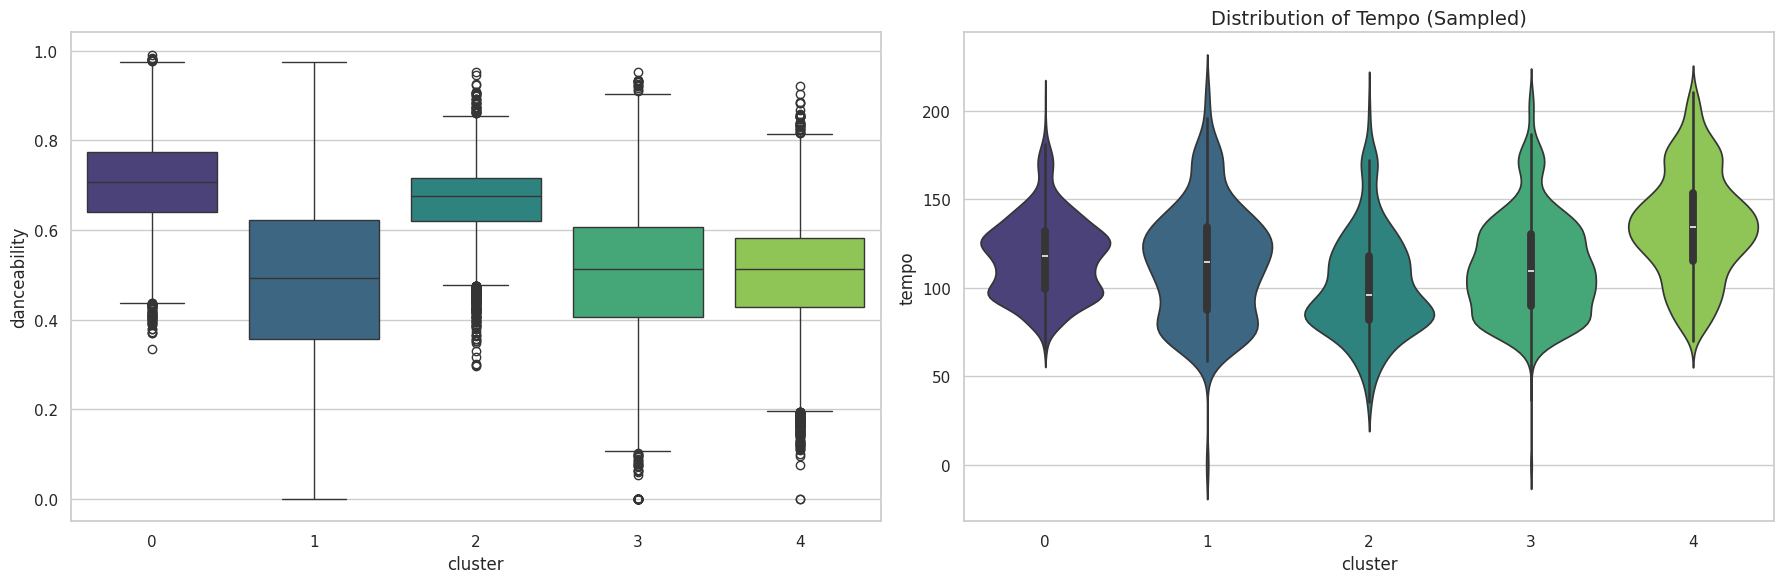

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA # Ensure this is imported

# 0. PERFORMANCE TWEAK: Sample the data if it's too large
# If df has > 10k rows, t-SNE will be very slow.
if len(df) > 5000:
    df_sample = df.sample(5000, random_state=42)
    X_scaled_sample = X_scaled[df_sample.index] # Assuming X_scaled is a numpy array
else:
    df_sample = df
    X_scaled_sample = X_scaled

sns.set_theme(style="whitegrid", palette="viridis")

# =========================================================
# 1. 2D SCATTER PLOTS (Optimized)
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# PCA is usually fast
pca = PCA(n_components=2)
pca_res = pca.fit_transform(X_scaled_sample)
sns.scatterplot(x=pca_res[:,0], y=pca_res[:,1], hue=df_sample['cluster'],
                palette='viridis', ax=axes[0], s=40, alpha=0.6)
axes[0].set_title('PCA: Linear Cluster Separation', fontsize=15)

# t-SNE optimized with 'learning_rate' and 'init'
# Also running on the sample only
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
tsne_res = tsne.fit_transform(X_scaled_sample)
sns.scatterplot(x=tsne_res[:,0], y=tsne_res[:,1], hue=df_sample['cluster'],
                palette='viridis', ax=axes[1], s=40, alpha=0.6)
axes[1].set_title('t-SNE: Complex Cluster Grouping (Sampled)', fontsize=15)

plt.tight_layout()
plt.show()

# =========================================================
# 3. BAR CHARTS (Speed Optimized)
# =========================================================
df_melted = df.melt(id_vars='cluster', value_vars=feature_cols,
                    var_name='Feature', value_name='Value')

plt.figure(figsize=(16, 8))
# errorbar=None removes the slow bootstrap calculation
sns.barplot(data=df_melted, x='Feature', y='Value', hue='cluster',
            palette='viridis', errorbar=None)
plt.title('Comparison of Average Feature Values by Cluster', fontsize=16)
plt.xticks(rotation=45)
plt.show()

# =========================================================
# 4. DISTRIBUTION PLOTS (Speed Optimized)
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

sns.boxplot(data=df, x='cluster', y='danceability', palette='viridis', ax=axes[0])

# For large data, violin plots are slow; if it still hangs, use boxenplot or sample df
sns.violinplot(data=df_sample, x='cluster', y='tempo', palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of Tempo (Sampled)', fontsize=14)

plt.tight_layout()
plt.show()

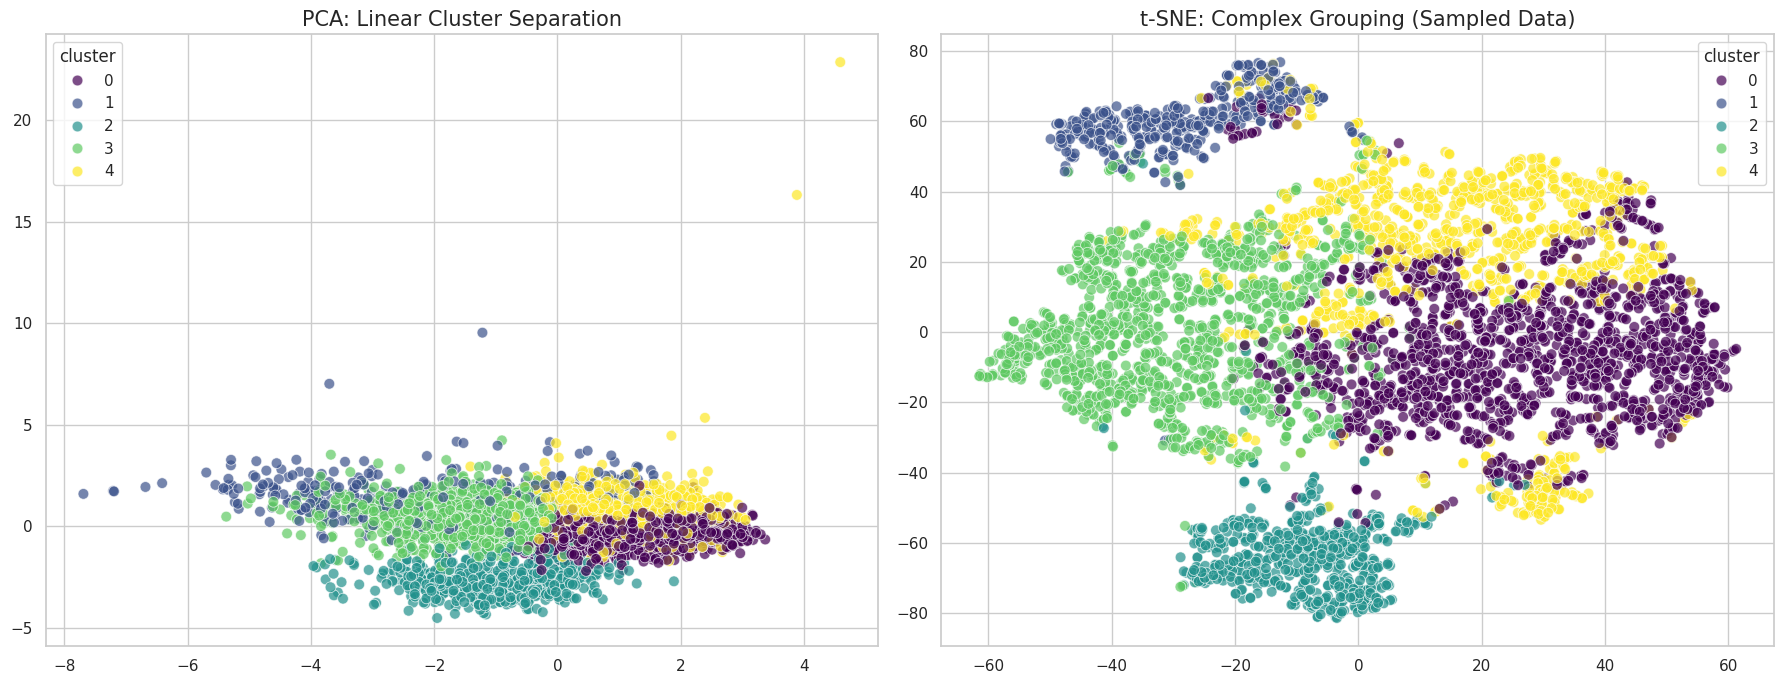

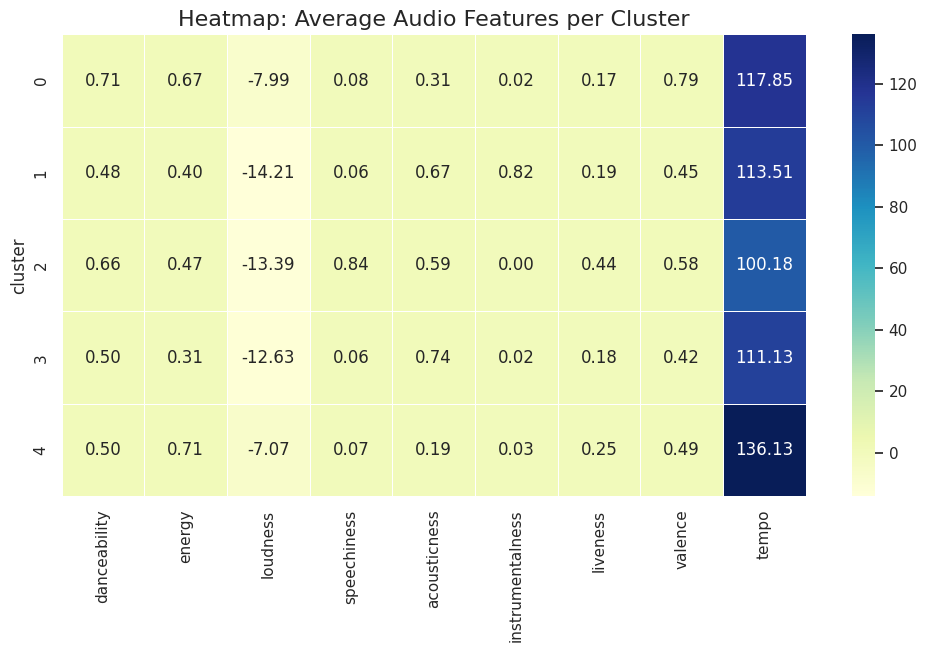

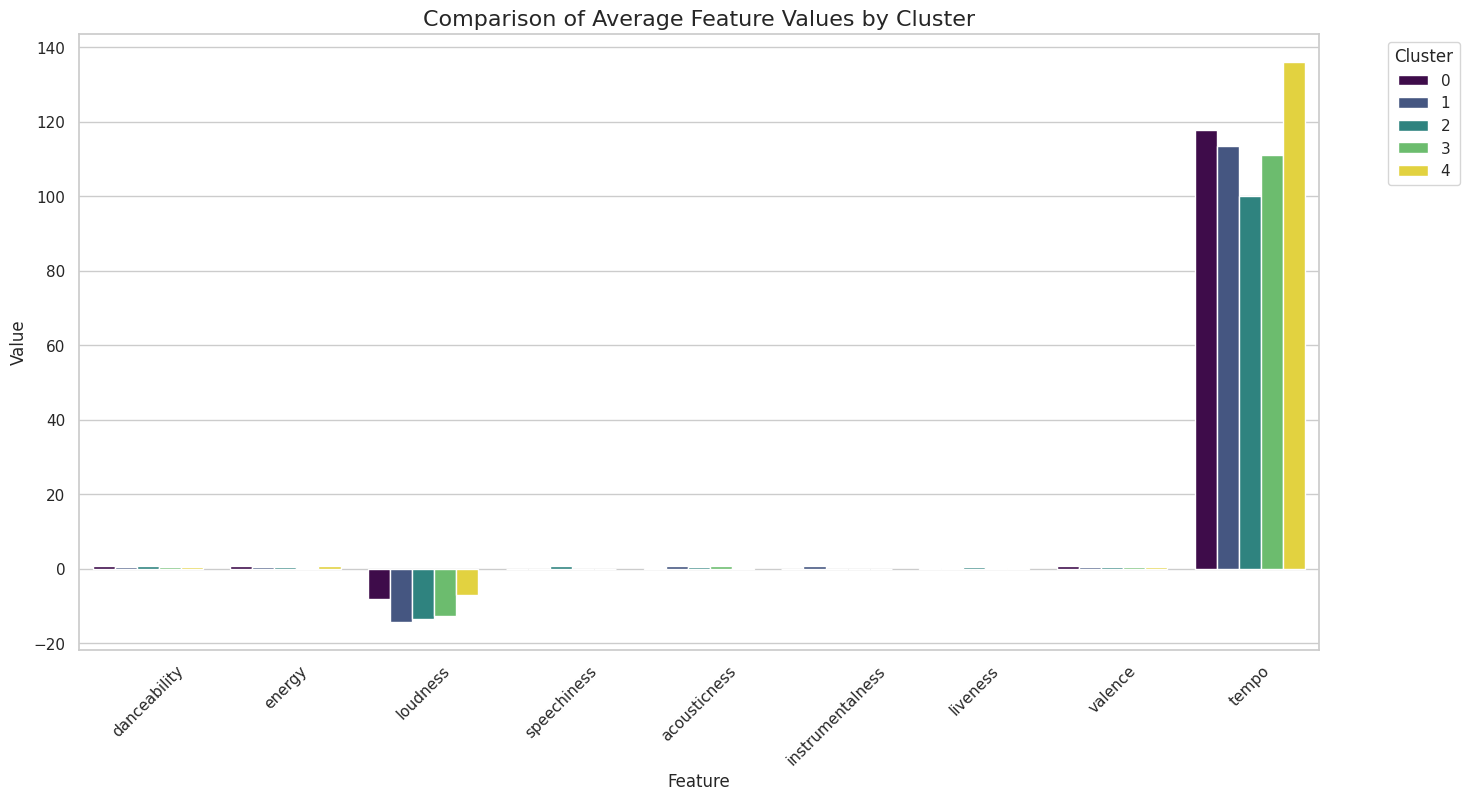

/tmp/ipython-input-3038670063.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='cluster', y='danceability', palette='viridis', ax=axes[0])
/tmp/ipython-input-3038670063.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df_sample, x='cluster', y='tempo', palette='viridis', ax=axes[1])


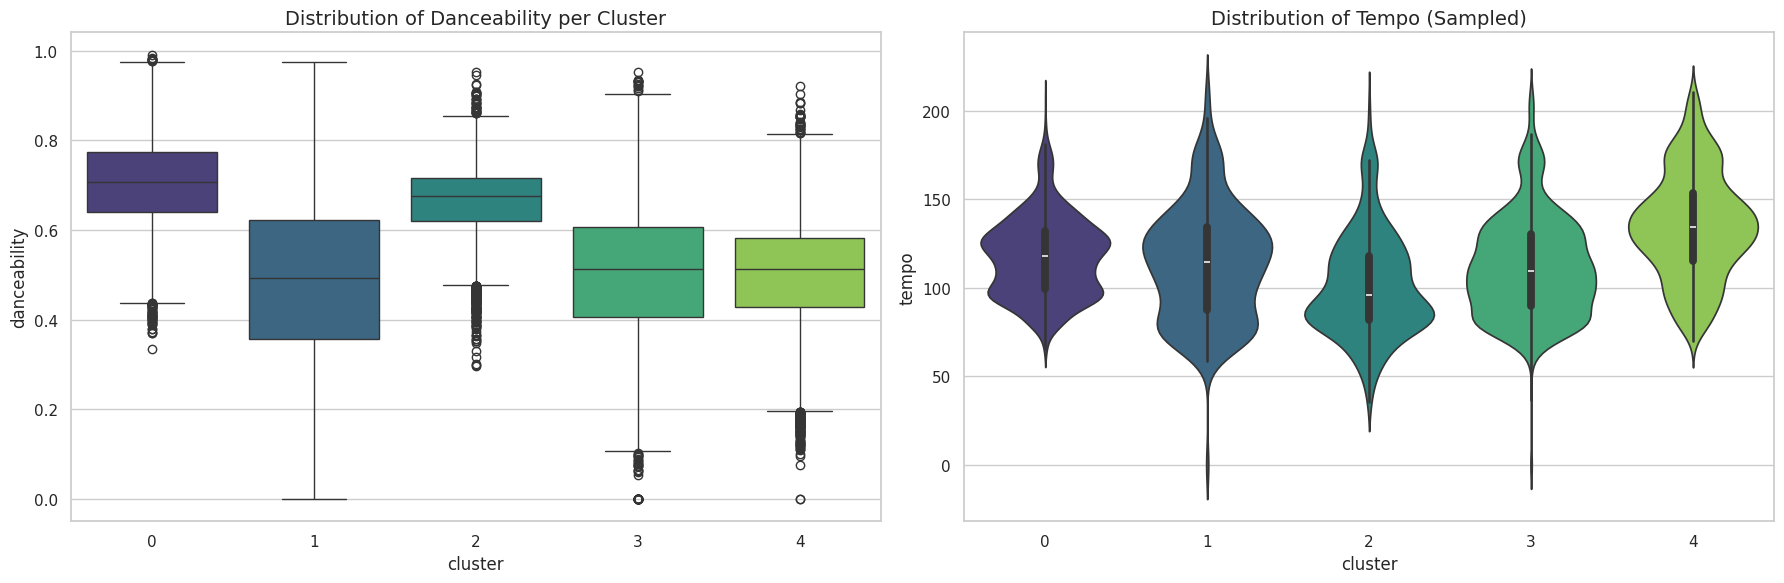

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import pandas as pd

# Set consistent styling
sns.set_theme(style="whitegrid", palette="viridis")
feature_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
                'instrumentalness', 'liveness', 'valence', 'tempo']

# PERFORMANCE CHECK: Sample data for computationally heavy visualizations (t-SNE)
# If your dataset is huge, t-SNE will hang. 5,000 points is usually plenty for a plot.
if len(df) > 5000:
    df_sample = df.sample(5000, random_state=42)
    X_scaled_sample = X_scaled[df_sample.index]
else:
    df_sample = df
    X_scaled_sample = X_scaled

# =========================================================
# 1. 2D SCATTER PLOTS (PCA & t-SNE) - Optimized
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# PCA (Fast)
pca = PCA(n_components=2)
pca_res = pca.fit_transform(X_scaled_sample)
sns.scatterplot(x=pca_res[:,0], y=pca_res[:,1], hue=df_sample['cluster'],
                palette='viridis', ax=axes[0], s=60, alpha=0.7)
axes[0].set_title('PCA: Linear Cluster Separation', fontsize=15)

# t-SNE (Slow - now using sample + optimized settings)
tsne = TSNE(n_components=2, perplexity=30, random_state=42, init='pca', learning_rate='auto')
tsne_res = tsne.fit_transform(X_scaled_sample)
sns.scatterplot(x=tsne_res[:,0], y=tsne_res[:,1], hue=df_sample['cluster'],
                palette='viridis', ax=axes[1], s=60, alpha=0.7)
axes[1].set_title('t-SNE: Complex Grouping (Sampled Data)', fontsize=15)

plt.tight_layout()
plt.show()

# =========================================================
# 2. HEATMAP (Feature Comparison Across Clusters)
# =========================================================
plt.figure(figsize=(12, 6))
# Calculate means (fast)
cluster_means = df.groupby('cluster')[feature_cols].mean()

# Normalizing the means for the heatmap makes differences easier to see
# (optional, but recommended if features have different scales like 'tempo' vs 'energy')
cluster_means_norm = (cluster_means - cluster_means.mean()) / cluster_means.std()

sns.heatmap(cluster_means, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=.5)
plt.title('Heatmap: Average Audio Features per Cluster', fontsize=16)
plt.show()

# =========================================================
# 3. BAR CHARTS (Aggregated Feature Values)
# =========================================================
df_melted = df.melt(id_vars='cluster', value_vars=feature_cols,
                    var_name='Feature', value_name='Value')

plt.figure(figsize=(16, 8))
# Added errorbar=None to prevent slow bootstrap calculations
sns.barplot(data=df_melted, x='Feature', y='Value', hue='cluster',
            palette='viridis', errorbar=None)
plt.title('Comparison of Average Feature Values by Cluster', fontsize=16)
plt.xticks(rotation=45)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# =========================================================
# 4. DISTRIBUTION PLOTS (Specific Features)
# =========================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Boxplot (Fast)
sns.boxplot(data=df, x='cluster', y='danceability', palette='viridis', ax=axes[0])
axes[0].set_title('Distribution of Danceability per Cluster', fontsize=14)

# Violin plot (Slower on large data, using sample for speed)
sns.violinplot(data=df_sample, x='cluster', y='tempo', palette='viridis', ax=axes[1])
axes[1].set_title('Distribution of Tempo (Sampled)', fontsize=14)

plt.tight_layout()
plt.show()

In [17]:
print("--- Sample Songs per Cluster ---")
for i in range(k):
    print(f"\nCluster {i} Sample Tracks:")
    display(df[df['cluster'] == i][['name_song', 'name_artists']].head(5))

# Export final dataset
df.to_csv('final_clustered_songs.csv', index=False)
print("\n✅ Success: 'final_clustered_songs.csv' has been created and is ready for download.")

--- Sample Songs per Cluster ---

Cluster 0 Sample Tracks:


,name_song,name_artists
15,On M'suit,Mistinguett
34,Je N'suis Pas Celle Que Vous Croyez,Perchicot
38,La Noce À Rebecca,Perchicot
89,My Heart,Louis Armstrong & His Hot Five
105,Put 'Em Down Blues,Louis Armstrong & His Hot Five



Cluster 1 Sample Tracks:


,name_song,name_artists
53,Veux Tu Que J'te Fasse Un Dessin,Georgius
65,West End Blues,Louis Armstrong & His Hot Five
67,Beau Koo Jack,Louis Armstrong & His Hot Five
69,Gut Bucket Blues,Louis Armstrong & His Hot Five
70,Skid-Dat-De-Dat,Louis Armstrong & His Hot Five



Cluster 2 Sample Tracks:


,name_song,name_artists
37,Dites Moi Doumergue,Perchicot
43,Il N'osait Pas Se Decider,Georgius
50,L'amour Excuse Tout,Georgius
55,Le Genre De La Maison,Georgius
60,Oh Oh Il Travaille Du Chapeau,Georgius



Cluster 3 Sample Tracks:


,name_song,name_artists
0,La Java,Mistinguett
1,En Douce,Mistinguett
2,J'en Ai Marre,Mistinguett
3,Ils n'ont pas ca,Mistinguett
4,La belote,Mistinguett



Cluster 4 Sample Tracks:


,name_song,name_artists
426,Hella Often Freestyle,Old Grape God
600,Ditty Diego,White Flag
601,100 Years from Now,White Flag
602,Jungle,White Flag
603,Don't Bring Me,White Flag



✅ Success: 'final_clustered_songs.csv' has been created and is ready for download.
